Import Genre data from CSV

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
movie_genre = pd.read_csv("./data/MovieGenre.csv",
                          sep=",", encoding='unicode_escape', index_col=None)
movie_genre.dropna(subset=['Genre','imdbId'], inplace=True)
movie_genre["Genre"] = movie_genre["Genre"].str.split("|")
display(movie_genre.head(4))
display(movie_genre.dtypes)
poster_urls = movie_genre['Poster']



,imdbId,Imdb Link,Title,IMDB Score,Genre,Poster
0,114709,http://www.imdb.com/title/tt114709,Toy Story (1995),8.3,"[Animation, Adventure, Comedy]",https://images-na.ssl-images-amazon.com/images...
1,113497,http://www.imdb.com/title/tt113497,Jumanji (1995),6.9,"[Action, Adventure, Family]",https://images-na.ssl-images-amazon.com/images...
2,113228,http://www.imdb.com/title/tt113228,Grumpier Old Men (1995),6.6,"[Comedy, Romance]",https://images-na.ssl-images-amazon.com/images...
3,114885,http://www.imdb.com/title/tt114885,Waiting to Exhale (1995),5.7,"[Comedy, Drama, Romance]",https://images-na.ssl-images-amazon.com/images...


imdbId          int64
Imdb Link      object
Title          object
IMDB Score    float64
Genre          object
Poster         object
dtype: object

Get all existing genres as list

In [67]:
def flatten(listToFlatten):
    return [item for sublist in listToFlatten for item in sublist]

genres = movie_genre["Genre"].array.tolist()
distinct_genres = list(set(flatten(genres)))
distinct_genres

['Crime',
 'Biography',
 'Music',
 'Fantasy',
 'Action',
 'Drama',
 'Sport',
 'Film-Noir',
 'Talk-Show',
 'Adult',
 'Comedy',
 'Family',
 'Reality-TV',
 'Sci-Fi',
 'Short',
 'Game-Show',
 'Adventure',
 'Animation',
 'Documentary',
 'Musical',
 'Romance',
 'Horror',
 'Western',
 'War',
 'History',
 'Mystery',
 'Thriller',
 'News']

Load Sample Images

In [85]:
import os
import cv2
samples_folder = "./data/SampleMoviePosters"
files = os.listdir(samples_folder)
sample_df = pd.DataFrame(columns=["imdbId", "img"])
sample_df.set_index("imdbId", inplace=True)
for file in files:
    id = int(file.replace(".jpg", ""))
    img = cv2.imread(os.path.join(samples_folder, file))
    scale_percent = 30  # percent of original size
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)
    resized = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)
    sample_df.loc[id, "img"] = resized
sample_df = pd.merge(sample_df, movie_genre,
                     left_index=True, right_on="imdbId")
sample_images = []
sample_labels = []
for i in sample_df.iloc():
    sample_images.append(i["img"])
    sample_labels.append(i["Genre"])
print(sample_images[0].shape, len(sample_labels))


(80, 54, 3) 1018


Download posters

In [2]:
import os
import urllib
images_path = "./data/posters/"
mkdir_cmd = "mkdir -p " + images_path
os.system(mkdir_cmd)
failed_downloads = []
for poster in poster_urls.itertuples():
    file_name = str(poster.imdbId) + ".jpg"
    if os.path.isfile(images_path + file_name):
        continue
    try:
        resource = urllib.request.urlretrieve(
            poster.Poster, images_path + file_name)
    except:
        failed_downloads.append(str(poster.Poster))
        continue
print("Failed downloads: " + str(failed_downloads))
if len(failed_downloads) == 0:
    print("All images downloaded successfully")


In [86]:
def get_encoding_for_genre(genre):
    # if is array, assume it is a list of genres
    if isinstance(genre, list):
        return [distinct_genres.index(g) for g in genre]
    return distinct_genres.index(genre)


def get_genre_for_encoding(encoding):
    return distinct_genres[encoding]


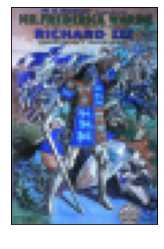

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [87]:
x = sample_images
y = sample_labels

plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(x[0])
plt.xlabel(y[0], color="white")
plt.show()

# encode genre list 
y_encoded = [get_encoding_for_genre(genre) for genre in y]

In [84]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
x = x
y = y_encoded

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu',
                           input_shape=x_train[0].shape),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(len(distinct_genres), activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=5)
model.evaluate(x_test, y_test)


ValueError: Failed to find data adapter that can handle input: (<class 'list'> containing values of types {"<class 'numpy.ndarray'>"}), (<class 'list'> containing values of types {'(<class \'list\'> containing values of types {"<class \'int\'>"})'})

Persist Model

In [25]:
model.save("./data/model")

INFO:tensorflow:Assets written to: ./data/model/assets


Load Model

In [27]:
model = tf.keras.models.load_model('./data/model')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
